# JTerm 2025 Physics 500
## VAE Clustering Optimization and BEC Transitions
### Omar Armbruster

# Overview

This project builds on the work from my Physics 704 project, which aimed to classify simulated Bose-Einstein Condensate (BEC) images using principal component analysis and a variational autoencoder (VAE). This project narrows the scope and focuses specifically on the VAE methods and applications. We first examine a high dimensional approach, which attempts to classify our BEC images without using any dimensional reduction techniques. We show that this method is not an effective classifier, thus justifying our choice to use unsupervised machine learning to solve the classification problem. We propose a new clustering method, which calculates an affinity matrix based on the overlap of the gaussians returned by the VAE's encoder. In addition to the conductance metric, we examine the eigenvectors and eigenvalues of the computed affinity matrix to evaluate the efficacy of the clustering. We also make modifications to our VAE model to allow for more optimal training while avoding overfitting. We implement an early stopping method and add functionality to allow for saving and loading trained models. Using these improvements to the VAE and the Gaussian Overlap clustering method, we are able to reduce the number of images in each dataset $S$ and the number of particles $N$ in each image while still achieving effective clustering. This allows us to zoom in on the transition from below $T_c$ to above $T_c$. 

# Load Data

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
import random
from scipy import constants
from scipy import linalg as lg
import sys
from sklearn.cluster import SpectralClustering
from VAE import VAE
import tensorflow as tf
import statistics

import os
os.environ["OMP_NUM_THREADS"] = '1'

2025-01-31 20:09:31.723322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 20:09:31.753448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-31 20:09:31.769261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-31 20:09:31.774140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 20:09:31.787125: I tensorflow/core/platform/cpu_feature_guar

In [2]:
subset = 100 #We laod datasets of 1600 images, but have found that we can achieve clustering using only 100 training images and 100 testing images
Ns = [100,500, 750, 1000] #Load datasets for 100, 500, 750, and 1000 particles in each image
data = []
test_data = []
temps = []
test_temps = []
params = []
test_params = []
Tcs = []
test_Tcs = []
for N in Ns:
    dataset = np.loadtxt(f'../../../Tensorflow/generated_data/TFBE_DoublePoisson_onCond_{N}_vnarrow.txt', delimiter=',')
    temp, *param = np.loadtxt(f'../../../Tensorflow/generated_data/TFBE_DoublePoisson_onCond_{N}_vnarrow_Temps.txt', delimiter=',')
    split = int(len(dataset) * (1/2))
    test_dataset = (dataset[split:])[:subset]
    test_temp = (temp[split:])[:subset]
    test_param = (np.array(param)[:,split:])[:,:subset]
    dataset = (dataset[:split])[:subset]
    temp = (temp[:split])[:subset]
    param = (np.array(param)[:, :split])[:,:subset]
    size = len(temp)
    test_size = len(test_temp)
    y = int(param[-1][0])
    test_y = int(test_param[-1][0])
    data.append(dataset.reshape(size,y,y))
    test_data.append(test_dataset.reshape(test_size, test_y, test_y))
    temps.append(temp)
    test_temps.append(test_temp)
    Tcs.append(param[0][0])
    test_Tcs.append(test_param[0][0])
    params.append(param)
    test_params.append(test_param)

# The Updated BEC Model

Our previous BEC model used a gaussian distribution to simulate image noise. While this was effective in allowing us to change the difficulty of the classification problem, it uniformly added noise to each pixel and did not account for fluctuations in the number of particles. Our new model uses poisson distributions to account for the fact that thermal fluctuations will change the number of particles in the condensate and that there will be higher noise near the center of the image where the majority of the particles are. Our model assumes that our system is in the canonical ensemble such that that number of particles $N$ will be fixed. We apply a poisson distribution to the number of particles in the condensate $N_o$ and calculate the number of particles in the atom cloud $N_{ex}$ such that $$N_{ex} = N - P(N_o)$$. Using these values, we calculate the density of each pixel in the image by summing the Thomas-Fermi approximation (for the condensate) and a Bose-Enhanced gaussian (for the atom cloud). We apply the poisson distribution to each pixel where the summed densities represent the mean of the distribution to find the final density $n(x,y)$ such that $$n(x,y) = P(n_o(x,y) + n_{ex}(x,y))$$

# High Dimensional Clustering (The Naive Approach)

We implement an approach to classify our BEC images without any dimensional reduction techniques. We expect this approach to fail, verifying that dimensional reduction is necessary to solve our classification problem. We calculate the distance $d$ between each image using the euclidian distance between their corresponding pixels such that $$d(X_i, X_j)^2 = \sum_{k = 0}^{size(X_i) - 1}(x_{ik} - x_{jk})^2$$. We convert this matrix to an affinity matrix using the gaussian formula such that $$a_{i,j} = e^{-\gamma * d_{i,j}^2}$$ where $\gamma$ is an arbitrary scaling constant. We feed this custom affinity matrix to spectral clustering, which returns a set of labels for the clustered images.

In [3]:
from HDCluster import HDCluster

In [4]:
%%capture
clusters = []
HDObjects = []
trueLabels = []
for i, dataset in enumerate(data):
    HD = HDCluster(n_clusters = 2, gamma = 0.5) # We want two clusters (above and below Tc) and arbitrarily choose a value for gamma
    cluster = HD.fit_predict(dataset) #Assigns cluster labels to each of our four datasets
    clusters.append(cluster)
    HDObjects.append(HD) #Want to save the fit HD objects for later analysis
    truelabel = np.array([0 if temp < Tcs[i] else 1 for temp in temps[i]]) #We can use the real labels to analyze the efficacy of our method
    trueLabels.append(truelabel)

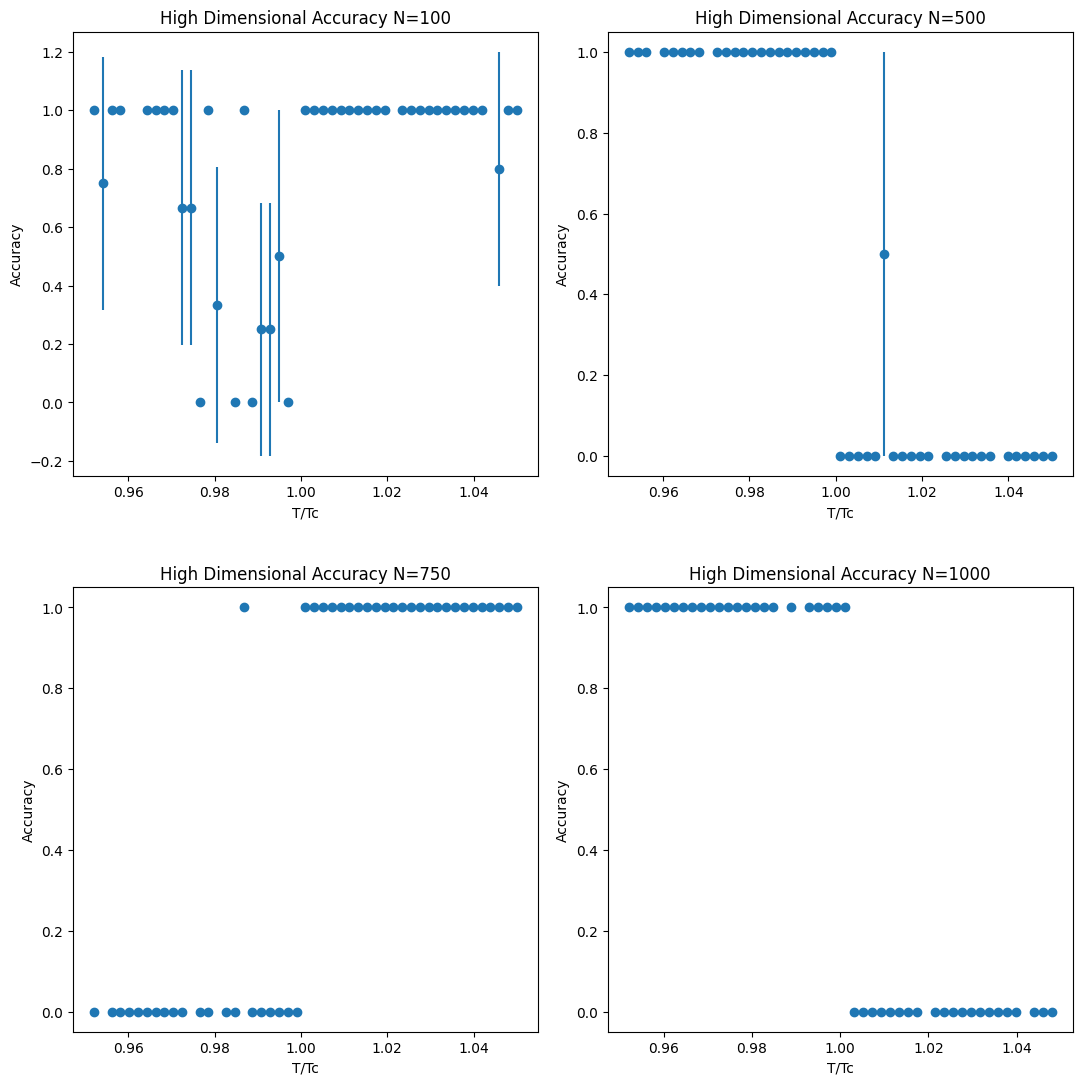

In [5]:
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
for i, HD in enumerate(HDObjects):
    ax = fig.add_subplot(2,2, i + 1)
    binTemp, binAccuracy = HD.cluster_accuracy(labels = trueLabels[i], binning = True, bin_range = (0.95, 1.05), xlabels = temps[i]/Tcs[i], bin_num = 50)
    plt.scatter(binTemp, binAccuracy[:,0])
    plt.errorbar(binTemp, binAccuracy[:,0], yerr = binAccuracy[:,1], fmt = 'none')
    plt.xlabel("T/Tc")
    plt.ylabel("Accuracy")
    plt.title(f"High Dimensional Accuracy N={Ns[i]}")

The plots above show that nearly all images on one side of $T_c$ are classified correctly and all images on the other side are classified incorrectly. This means that this method is putting nearly all of the images in a single cluster, giving us no meaningful information. 

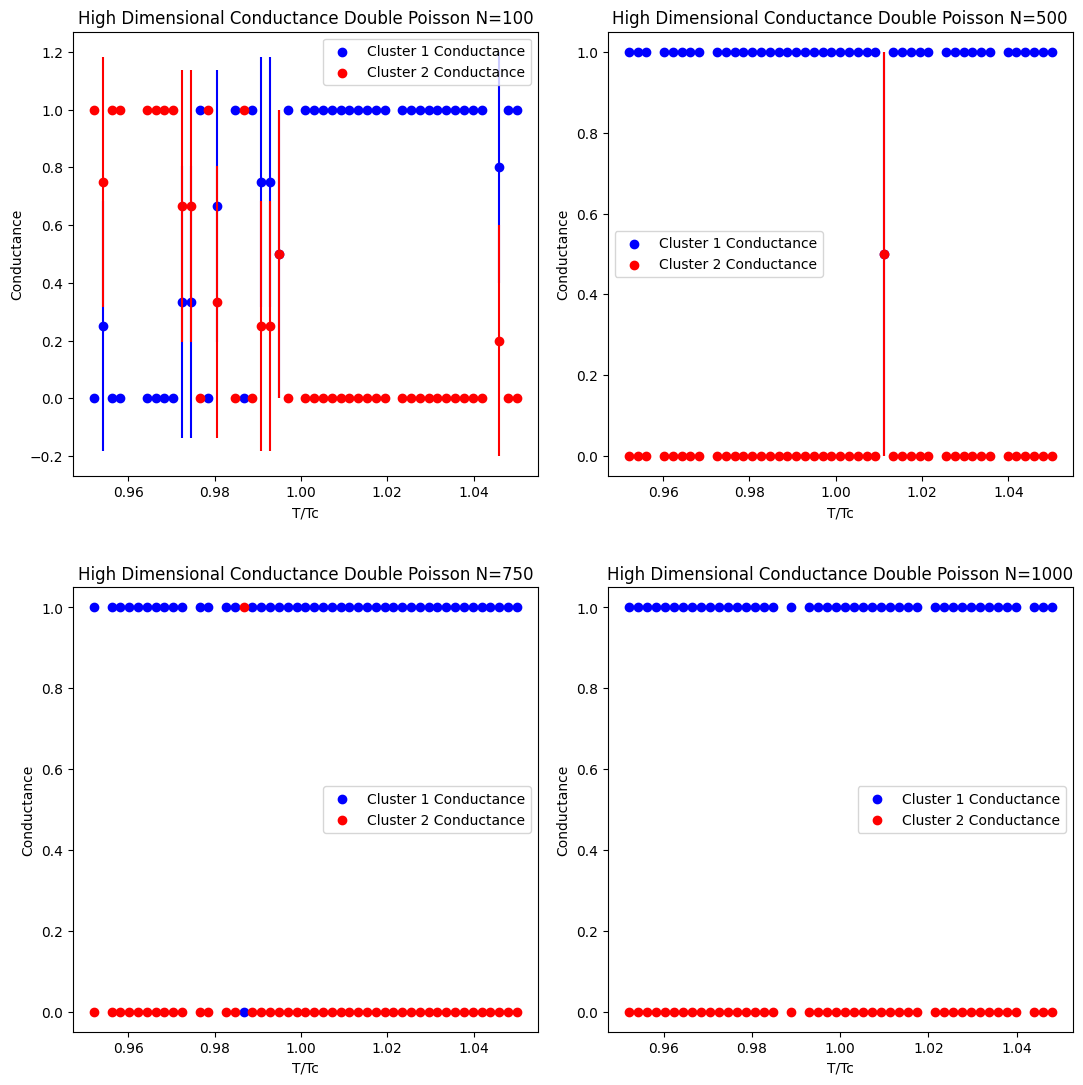

In [6]:
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
for i, HD in enumerate(HDObjects):
    ax = fig.add_subplot(2,2, i + 1)
    binTemp, binConductance0, binConductance1 = HD.calculate_conductances(binning = True, bin_range = (0.95, 1.05), xlabels = temps[i]/Tcs[i], bin_num = 50)
    plt.scatter(binTemp, binConductance0[:,0], label = 'Cluster 1 Conductance', color = 'Blue')
    plt.errorbar(binTemp, binConductance0[:,0], yerr = binConductance0[:,1], fmt = 'none', color = 'Blue')
    plt.scatter(binTemp, binConductance1[:,0], label = 'Cluster 2 Conductance', color = 'Red')
    plt.errorbar(binTemp, binConductance1[:,0], yerr = binConductance1[:,1], fmt = 'none', color = 'Red')
    plt.legend()
    plt.xlabel("T/Tc")
    plt.ylabel("Conductance")
    plt.title(f"High Dimensional Conductance Double Poisson N={Ns[i]}")

There are no meaningful transitions for the $N = 500$, $750$, and $1000$ datasets and the $N = 100$ transition is not clear enough for any meaningful information to be extrapolated, indicating that this is not an effective clustering method.

# VAE Training Optimization

In order to test the efficacy of our VAE in the small dataset and small $N$ regimes, we need to optimize the training process to ensure that we are finding a true limit. One important aspect of this is ensuring that the VAE models are trained for an adequate number of epochs without any overtraining. We accomplish this by implementing an early stopping procedure that stops the training if there is no improvement in the loss for a certain number of epochs. 

Using the patience parameter, we specify the number of epochs that the model can continue training without any improvement before stopping. We determine if the model has stopped improving by looking at the loss $L$ for the past $p$ epochs where $p$ is the patience parameter. We then divide these $p$ losses into a first half and a second half where the first half is the $p/2$ least recent epochs. We take the mean of both halves and stop the training if the difference between them is less than the standard error squared such that $$|\bar{L}[:\frac{p}{2}] - \bar{L}[\frac{p}{2}:]| < \sigma^2_{L[:\frac{p}{2}]} + \sigma^2_{L[\frac{p}{2}:]} $$

In [7]:
%%time
vae = VAE(data[0], test_data[0], batch_size = 32, epochs = 3000, patience = 50)
loss = vae.get_loss()
train_loss = vae.get_train_loss()

Epoch: 592, Test set ELBO: -41.00367736816406, time elapse for current epoch: 0.018540143966674805
CPU times: user 1min 9s, sys: 9.64 s, total: 1min 19s
Wall time: 1min 10s


Despite the model being told to run for $3000$ epochs, it stops training after $619$ due to the early stopping condition. We plot a horizontal line containing the average loss over the past $50$ epochs, which verifies that the loss has indeed plateaued and is no longer improving.

Text(0.5, 1.0, 'Loss vs Epoch N = 100')

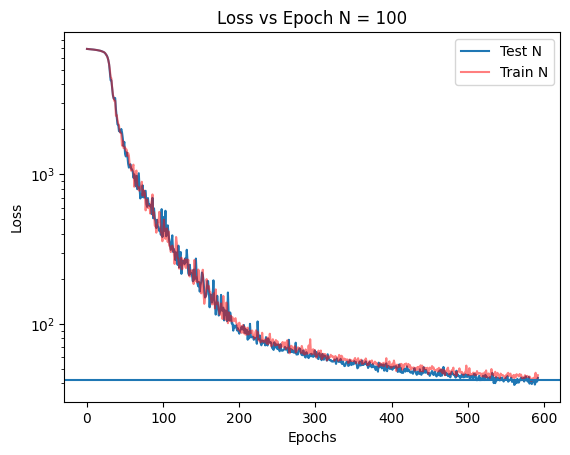

In [8]:
plt.plot(loss, label = 'Test N')
plt.plot(train_loss, label = 'Train N', color = 'red', alpha = 0.5)
plt.axhline(np.mean(loss[-50:]))
plt.legend()
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss vs Epoch N = 100')

We implemented functionality that allows us load pretrained models. This reduces redundant training and allows us to recreate past results. Future work will allow us to continue training on already trained models. The remainder of the plots in this notebook will use the encoded data from these pretrained models.

In [9]:
loadedVAEs = [VAE(load =f'../../../Tensorflow/VAEModels/Part{Ns[i]}Size100_vnarrow.keras') for i in range(len(Ns))]
fitImgs = np.array([vae.encode(data[i]) for i, vae in enumerate(loadedVAEs)])
fitSTDs = np.array([np.exp(vae.encode(data[i], False))**0.5 for i, vae in enumerate(loadedVAEs)])
test_fitImgs = np.array([vae.encode(test_data[i]) for i, vae in enumerate(loadedVAEs)])
test_fitSTDs = np.array([np.exp(vae.encode(test_data[i], False))**0.5 for i, vae in enumerate(loadedVAEs)])

W0000 00:00:1738372260.893451 3499826 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738372260.894108 3499826 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738372260.894634 3499826 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738372260.895169 3499826 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738372260.895708 3499826 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738372260.896272 3499826 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738372260.896798 3499826 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738372260.897381 3499826 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738372260.897979 3499826 gp

The VAE returns the dimensionally reduced images as a set of means, which we have colored by their true labels. Even with such a small range in temperature ($0.95T_c$ to $1.05T_c$), the VAE is able to separate the images into fairly distinct clusters, which align with their true labels. As we would expect, the clusters are more distinct for larger values of $N$, as the features of each image are more distinct.

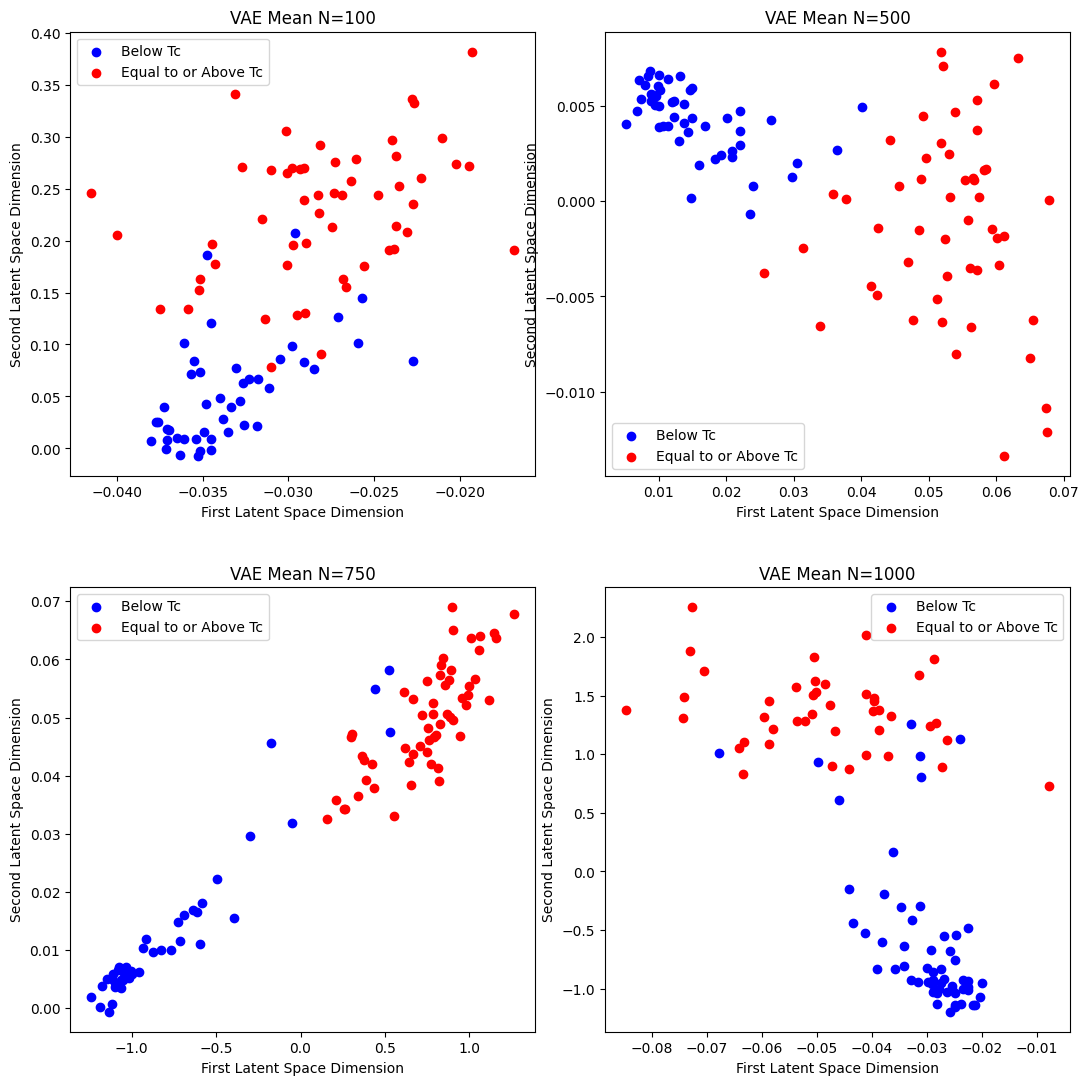

In [10]:
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
for i, dataset in enumerate(data):
    ax = fig.add_subplot(2,2, i + 1)
    group1 = fitImgs[i][temps[i] < Tcs[i]]
    group2 = fitImgs[i][temps[i] >= Tcs[i]]
    plt.scatter(group1[:, 0], group1[:,1], label = 'Below Tc', color = 'Blue')
    plt.scatter(group2[:,0], group2[:,1], label = 'Equal to or Above Tc', color = 'Red')
    plt.xlabel('First Latent Space Dimension')
    plt.ylabel('Second Latent Space Dimension')
    plt.legend()
    plt.title(f'VAE Mean N={Ns[i]}')

The VAE also returns the log-variance of the dimensionally reduced data, which we convert to the standard deviation. We also observe fairly distinct clustering for the larger $N$ values, indicating a clear separation between the two types of images. However, the standard deviations in some cases are much larger than the means, which could explain why we sometimes don't see a transition in the conductance plots when using the gaussian overlap method explained below.

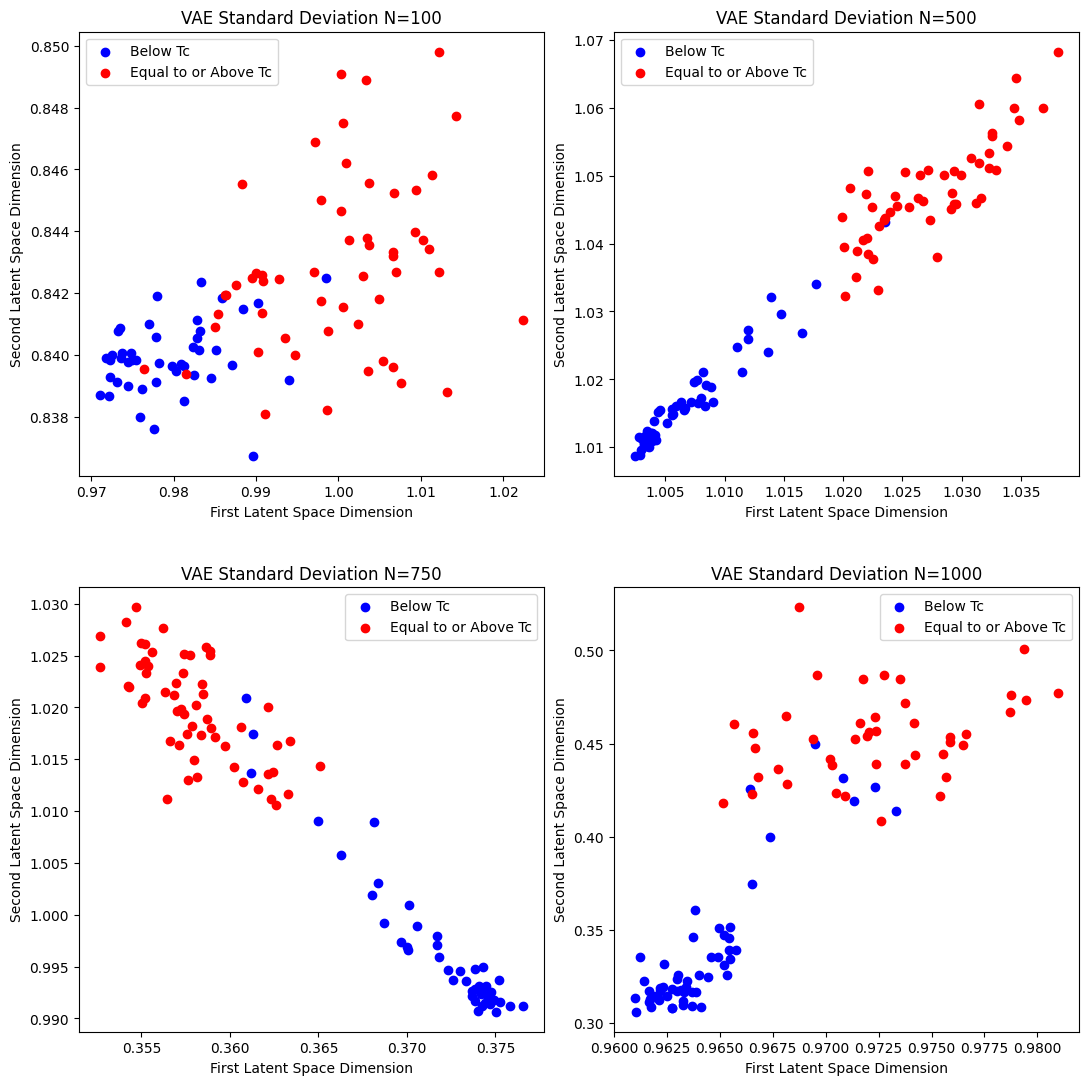

In [11]:
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
for i, dataset in enumerate(data):
    ax = fig.add_subplot(2,2, i + 1)
    group1 = fitSTDs[i][temps[i] < Tcs[i]]
    group2 = fitSTDs[i][temps[i] >= Tcs[i]]
    plt.scatter(group1[:, 0], group1[:,1], label = 'Below Tc', color = 'Blue')
    plt.scatter(group2[:,0], group2[:,1], label = 'Equal to or Above Tc', color = 'Red')
    plt.xlabel('First Latent Space Dimension')
    plt.ylabel('Second Latent Space Dimension')
    plt.legend()
    plt.title(f'VAE Standard Deviation N={Ns[i]}')

In [12]:
def closestNearestNeighborDist(fitImgs):
    """
    Calculates the distance of the nearest neighbor in one dimension for a given latent space representation
    """
    shortest_dist = [np.min(np.abs(np.delete(fitImgs, i) - fitImgs[i])) for i in range(len(fitImgs))]
    return np.array(shortest_dist)

def meanNearestNeighborDist(fitImgs, clusters):
    """
    Calculates the mean distance from each point to all other points in the same cluster
    """
    mean_dist = [np.mean(np.abs(np.delete(fitImgs,i)[np.delete(clusters,i) == clusters[i]] - fitImgs[i])) for i in range(len(fitImgs))]
    return np.array(mean_dist)

As a preliminary test for our gaussian overlap method, we plot the standard deviation latent space dimensions against the distance of the mean latent space representations to their nearest neighbor as well as the mean distance of each mean latent space representation to the other latent space representations in their cluster. If the distances between points are smaller than the latent space representation, then we know that the gaussians we create from the mean and standard deviation representations will have an overlap. If the distances were not much smaller than the standard deviations, there would not be any overlap and we would not be able to form any discernable clusters.

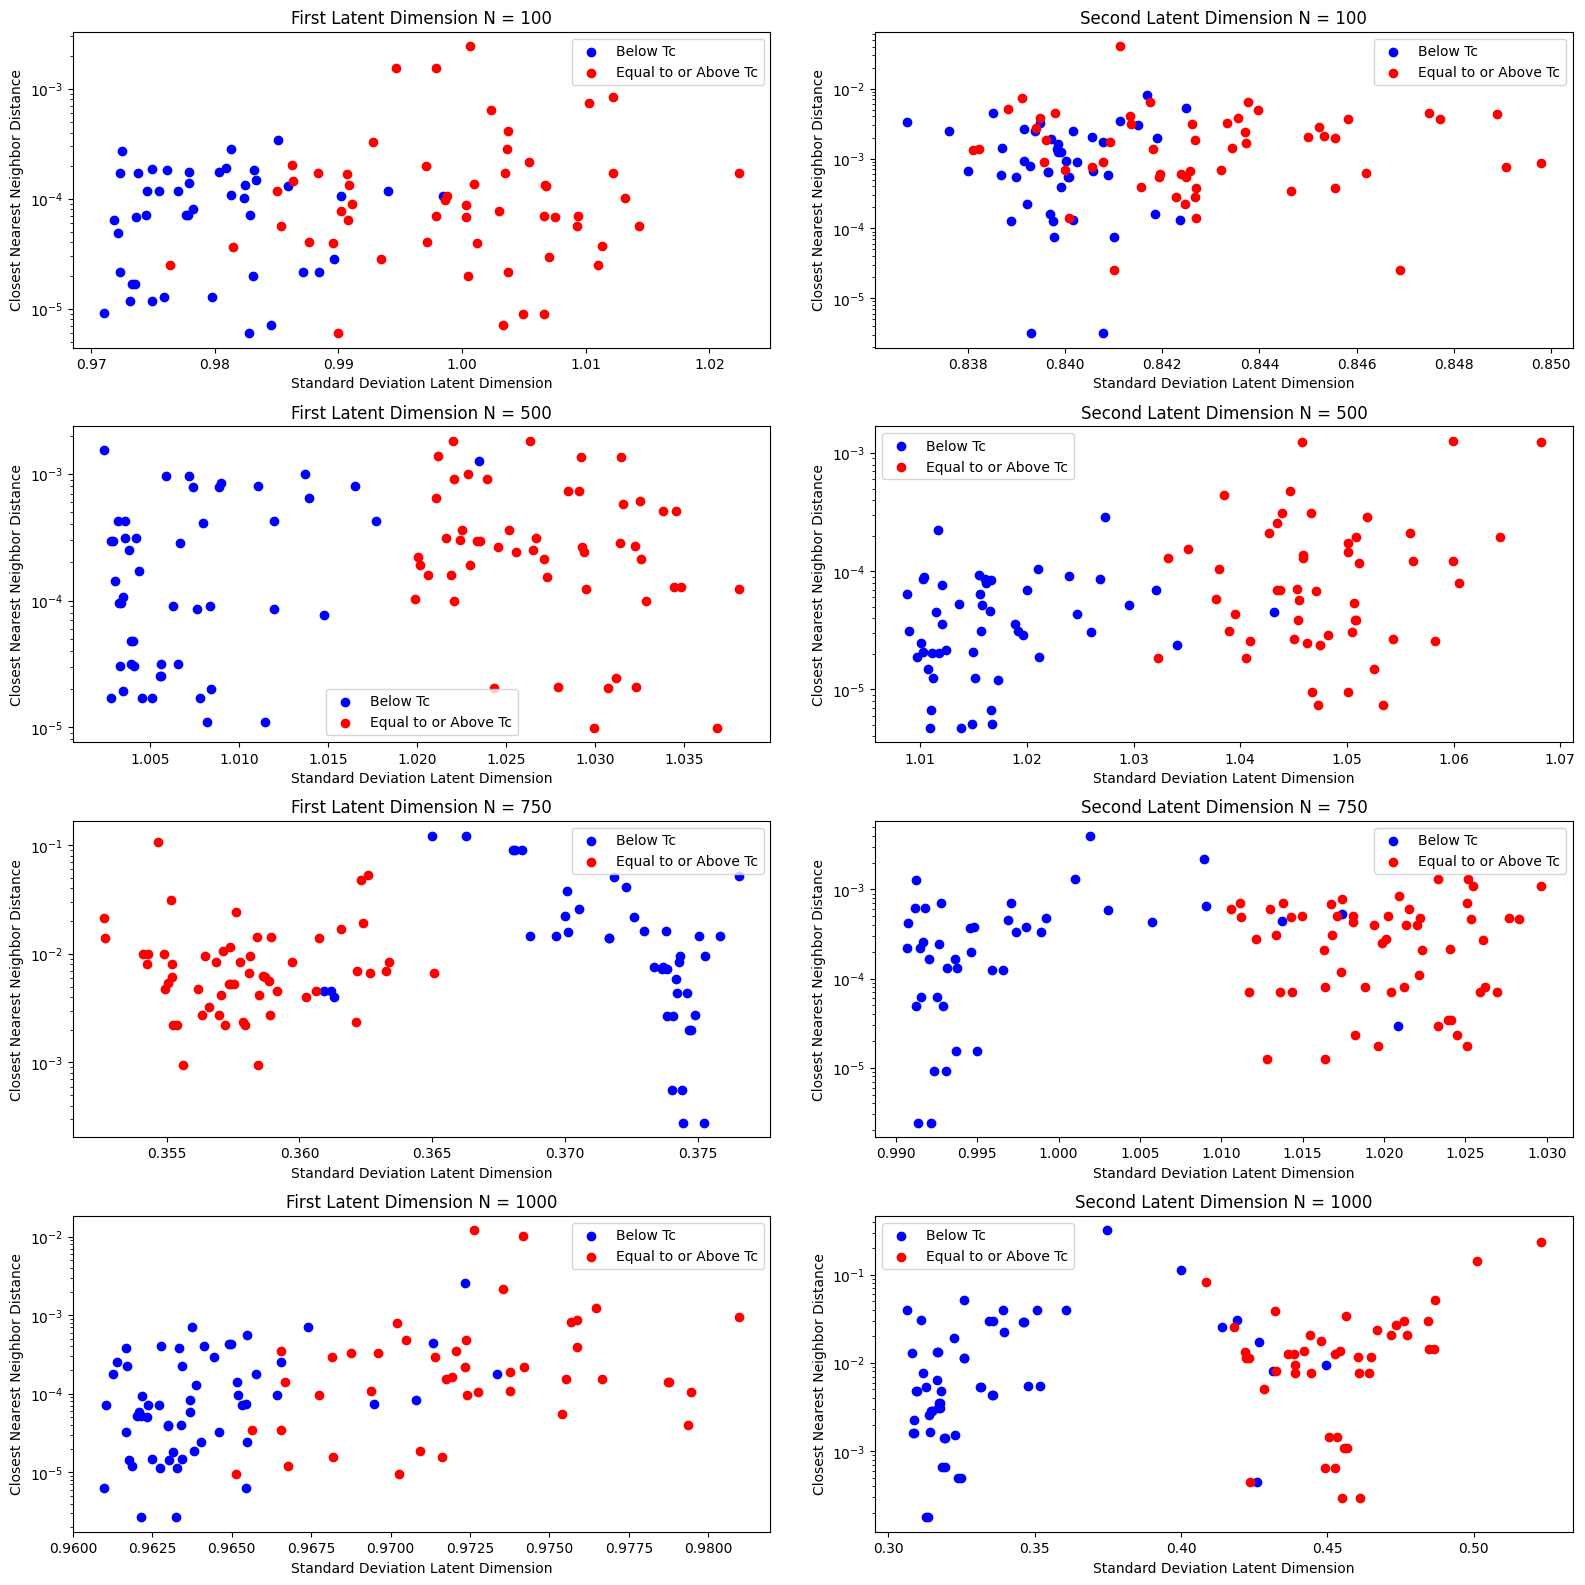

In [13]:
Titles = ["First Latent Dimension", "Second Latent Dimension"]
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
j = 0
for idx in range(len(data)):
    for ld in range(len(fitImgs[idx][0])):
        ax = fig.add_subplot(4,2, j + 1)
        shortest_dist = closestNearestNeighborDist(fitImgs[idx][:,ld])
        group1x = fitSTDs[idx][temps[idx] < Tcs[idx]][:,ld]
        group2x = fitSTDs[idx][temps[idx] >= Tcs[idx]][:,ld]
        group1y = shortest_dist[temps[idx] < Tcs[idx]]
        group2y = shortest_dist[temps[idx] >= Tcs[idx]]
        plt.scatter(group1x, group1y, label = 'Below Tc', color = 'Blue')
        plt.scatter(group2x, group2y, label = 'Equal to or Above Tc', color = 'Red')
        plt.legend()
        plt.title(Titles[ld] + f' N = {Ns[idx]}')
        plt.xlabel('Standard Deviation Latent Dimension')
        plt.ylabel('Closest Nearest Neighbor Distance')
        plt.yscale('log')
        j+=1

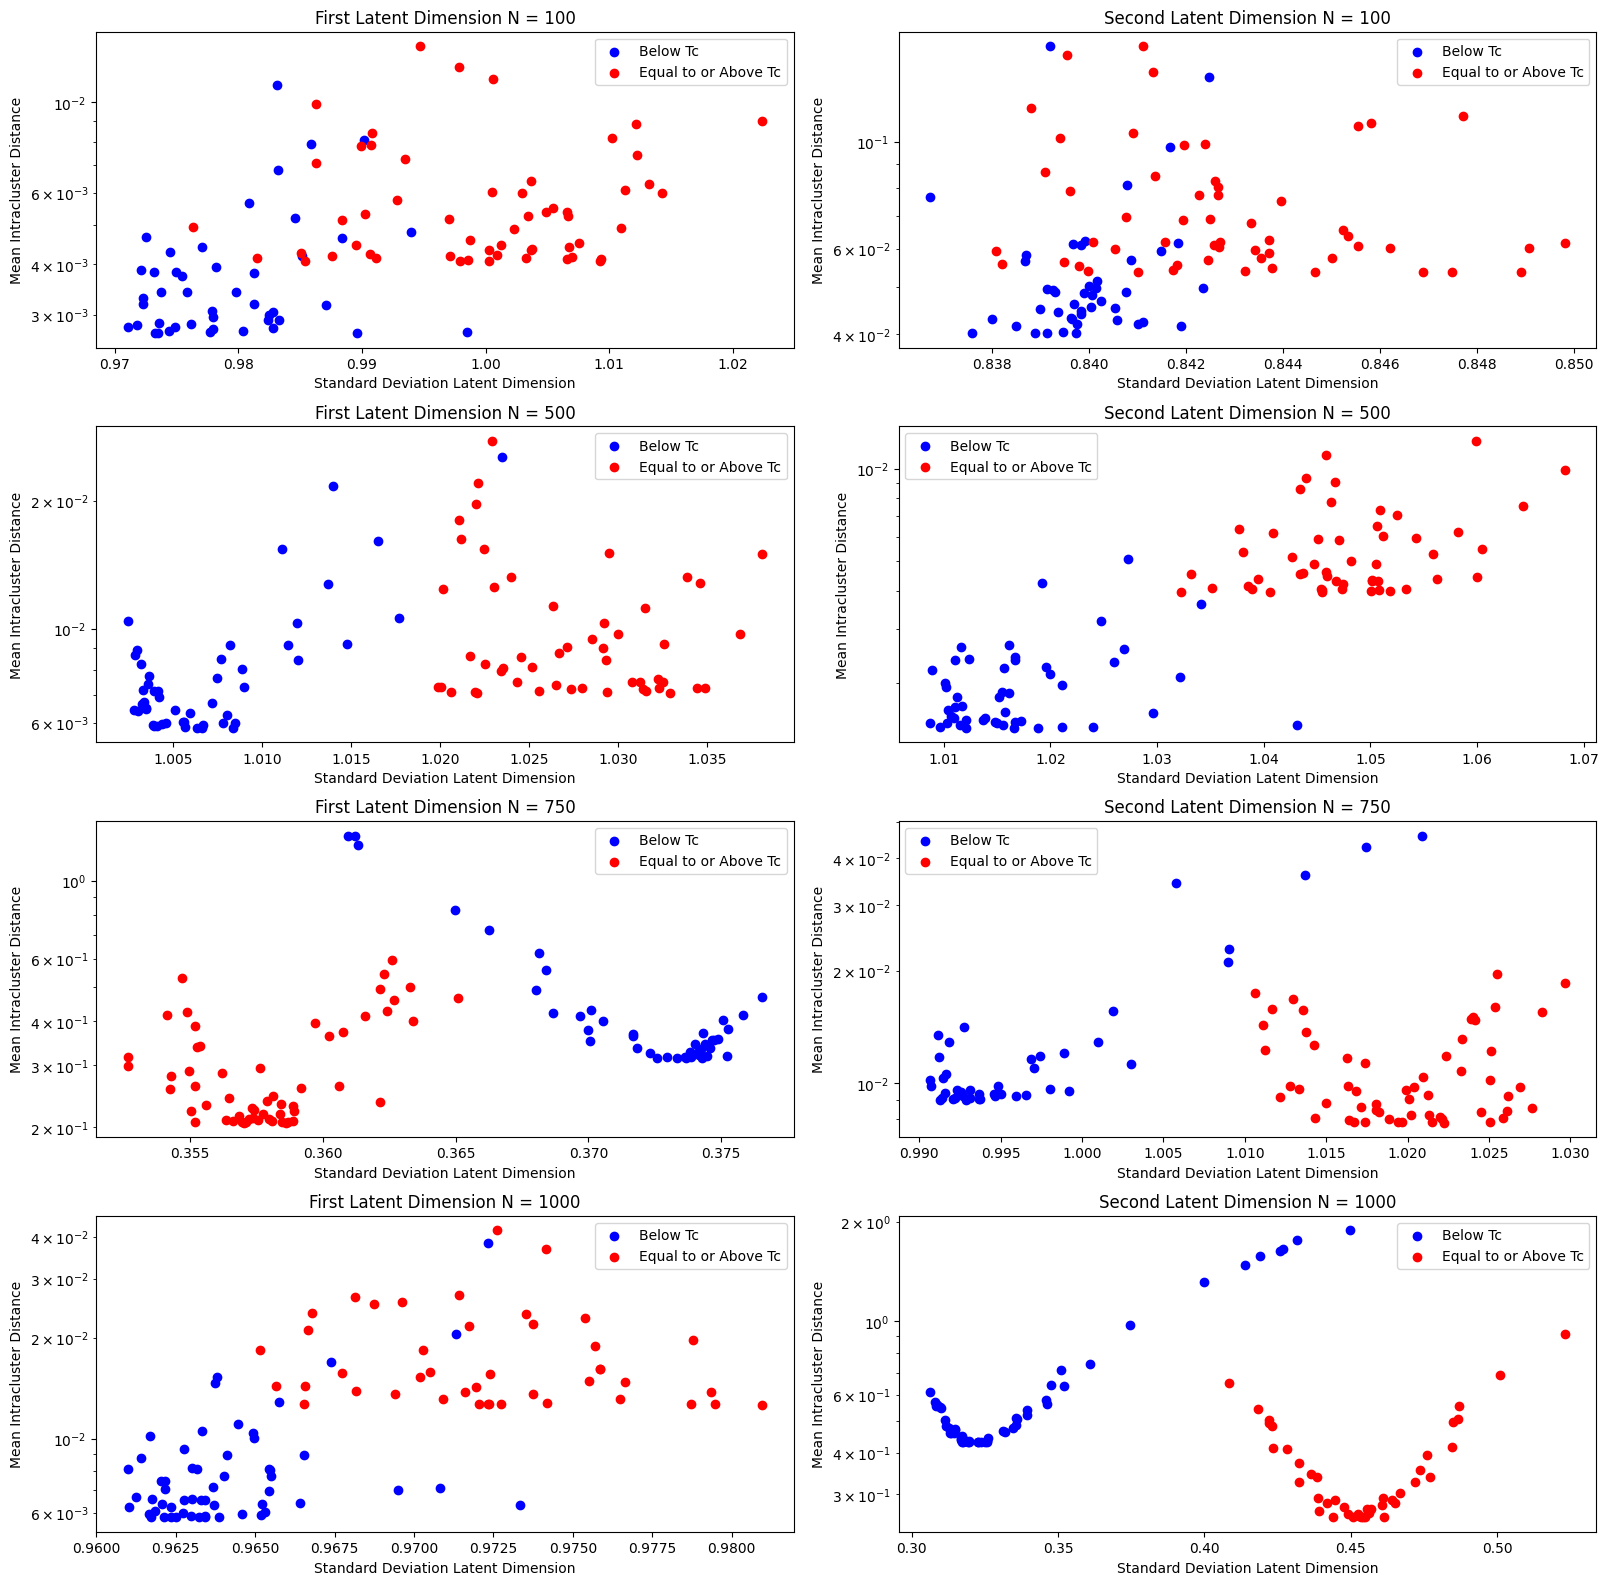

In [14]:
Titles = ["First Latent Dimension", "Second Latent Dimension"]
trueClusters = [[1 if temp < Tcs[i] else 0 for temp in temps[i]] for i in range(len(data))]
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
j = 0
for idx in range(len(data)):
    for ld in range(len(fitImgs[idx][0])):
        ax = fig.add_subplot(4,2, j + 1)
        mean_dist = meanNearestNeighborDist(fitImgs[idx][:,ld], trueClusters[idx])
        group1x = fitSTDs[idx][temps[idx] < Tcs[idx]][:,ld]
        group2x = fitSTDs[idx][temps[idx] >= Tcs[idx]][:,ld]
        group1y = mean_dist[temps[idx] < Tcs[idx]]
        group2y = mean_dist[temps[idx] >= Tcs[idx]]
        plt.scatter(group1x, group1y, label = 'Below Tc', color = 'Blue')
        plt.scatter(group2x, group2y, label = 'Equal to or Above Tc', color = 'Red')
        plt.legend()
        plt.title(Titles[ld] + f' N = {Ns[idx]}')
        plt.xlabel('Standard Deviation Latent Dimension')
        plt.ylabel('Mean Intracluster Distance')
        plt.yscale('log')
        j += 1

# Gaussian Overlap Clustering

The VAE's encoder returns each dimensionally reduced image expressed as a mean and a log-variance. Past clustering methods have just focused on the means of the images, but this approach seeks to use all of the information provided. We convert the returned log-variance $logvar$ to a standard deviation $\sigma$ such that $$\sigma = e^{\frac{logvar}{2}}$$ and use this and the mean to represent each image as a gaussian. We calculate the affinity between two images based on how strongly their two gaussians overlap. Using the overlap function from the statistics package, we calculate the overlap of the two gaussians in the $x$ and $y$ directions. We combine these two overlaps for a total affinity by multiplying them such that $$a_{X_i, X_j} = overlap(X_{ix}, X_{jx}) * overlap(X_{iy}, X_{jy})$$

In [27]:
from GaussianOverlapCluster import GaussianOverlap

In [28]:
clusters = []
OverlapObjects = []
trueLabels = []
for i, fitImg in enumerate(fitImgs):
    Overlap = GaussianOverlap(n_clusters = 2) # We want two clusters (above and below Tc). We do not have a gamma so there are no free parameters
    cluster = Overlap.fit_predict(fitImg, fitSTDs[i]) #Assigns cluster labels to each of our four datasets
    clusters.append(cluster)
    OverlapObjects.append(Overlap) #Want to save the fit Overlap objects for later analysis
    truelabel = np.array([0 if temp < Tcs[i] else 1 for temp in temps[i]]) #We can use the real labels to analyze the efficacy of our method
    trueLabels.append(truelabel)

To verify that our models aren't overtrained, we can plot the conductances of the testing data as well. If we observe a transition in the conductance, then we can assume that the model is adequately trained but not overfit. To accomplish this, we need to calculate another set of overlap matrices on the dimensionally reduced testing data.

In [29]:
test_clusters = []
test_OverlapObjects = []
test_trueLabels = []
for i, test_fitImg in enumerate(test_fitImgs):
    Overlap = GaussianOverlap(n_clusters = 2) # We want two clusters (above and below Tc). We do not have a gamma so there are no free parameters
    cluster = Overlap.fit_predict(test_fitImg, test_fitSTDs[i]) #Assigns cluster labels to each of our four datasets
    clusters.append(cluster)
    test_OverlapObjects.append(Overlap) #Want to save the fit Overlap objects for later analysis
    truelabel = np.array([0 if temp < test_Tcs[i] else 1 for temp in test_temps[i]]) #We can use the real labels to analyze the efficacy of our method
    test_trueLabels.append(truelabel)

Since we have the true labels for each image, we can plot the accuracy as a quick verification that the method is effective and working as intended. However, since our ultimate goal is to be able to use unsupervised learning to classify images without labels, we need to use the conductance as well. The accuracies shown below seem to indicate that there is some uncertainty close to $T_c$ and with smaller values of $N$, but the method is otherwise quite effective.

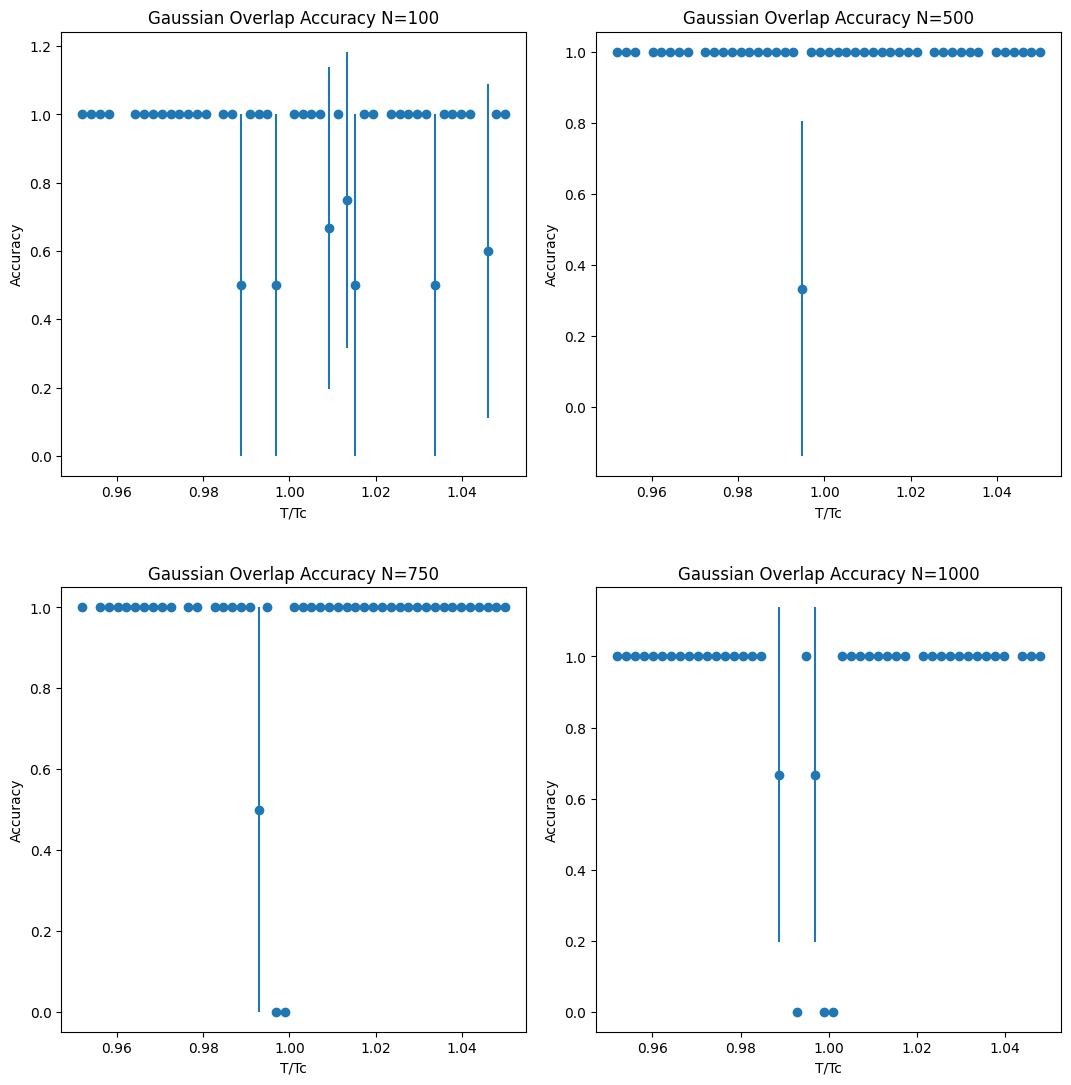

In [30]:
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
for i, Overlap in enumerate(OverlapObjects):
    ax = fig.add_subplot(2,2, i + 1)
    binTemp, binAccuracy = Overlap.cluster_accuracy(labels = trueLabels[i], binning = True, bin_range = (0.95, 1.05), xlabels = temps[i]/Tcs[i], bin_num = 50)
    plt.scatter(binTemp, binAccuracy[:,0])
    plt.errorbar(binTemp, binAccuracy[:,0], yerr = binAccuracy[:,1], fmt = 'none')
    plt.xlabel("T/Tc")
    plt.ylabel("Accuracy")
    plt.title(f"Gaussian Overlap Accuracy N={Ns[i]}")

As we decrease the value of $N$, the conductance transition becomes more smooth, allowing us to observe how the certainty of our models change as we approach $T_c$. At $N = 750$, we can observe a fairly smooth transition at $T_c$ from high conductance to low conductance. We cannot observe a transition at $N = 500$ (even with extensive training), demonstrating a shortcoming of our method. It appears in certain datasets, there is not sufficient overlap between the gaussians to demonstrate a conductance transition.

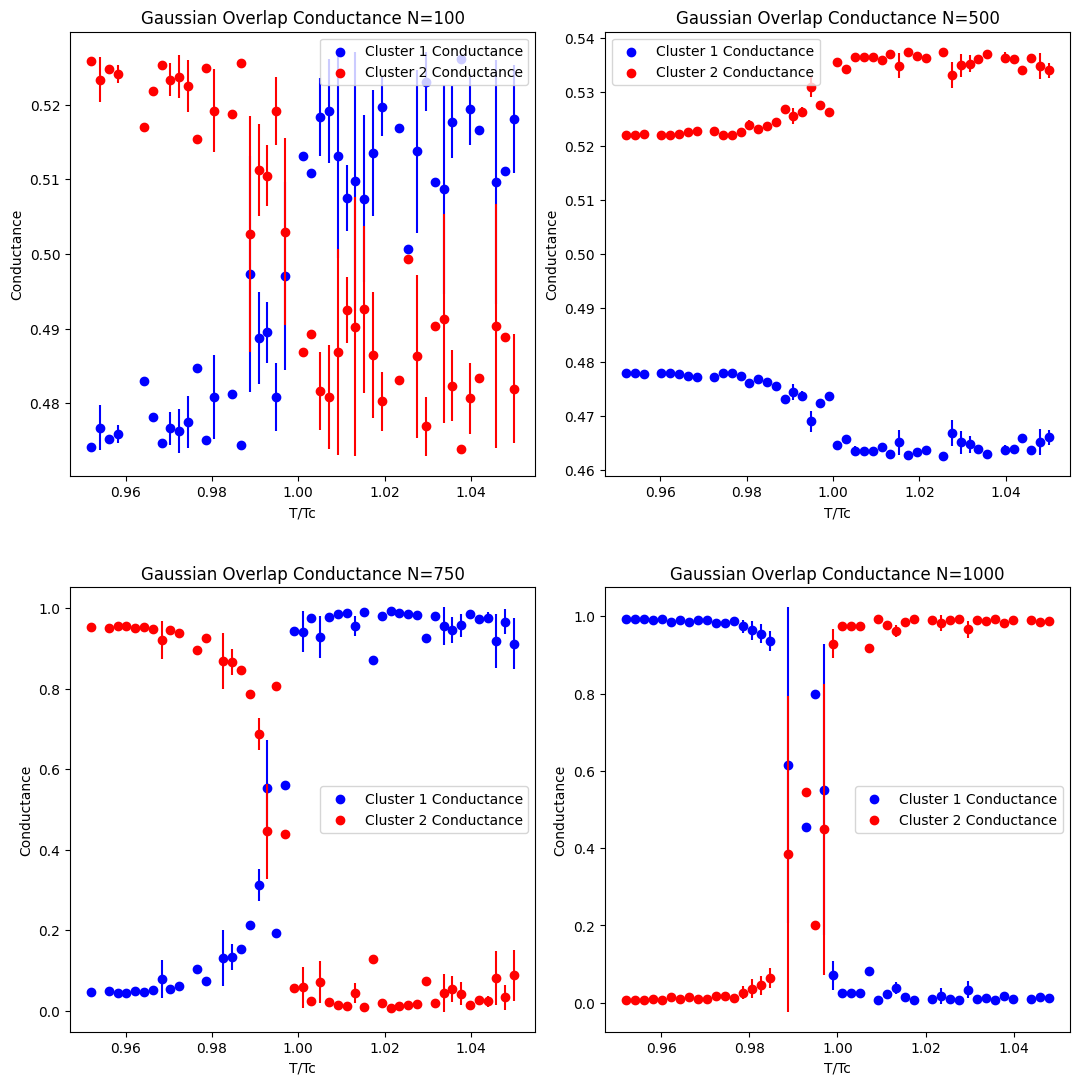

In [31]:
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
for i, Overlap in enumerate(OverlapObjects):
    ax = fig.add_subplot(2,2, i + 1)
    binTemp, binConductance0, binConductance1 = Overlap.calculate_conductances(binning = True, bin_range = (0.95, 1.05), xlabels = temps[i]/Tcs[i], bin_num = 50)
    plt.scatter(binTemp, binConductance0[:,0], label = 'Cluster 1 Conductance', color = 'Blue')
    plt.errorbar(binTemp, binConductance0[:,0], yerr = binConductance0[:,1], fmt = 'none', color = 'Blue')
    plt.scatter(binTemp, binConductance1[:,0], label = 'Cluster 2 Conductance', color = 'Red')
    plt.errorbar(binTemp, binConductance1[:,0], yerr = binConductance1[:,1], fmt = 'none', color = 'Red')
    plt.legend()
    plt.xlabel("T/Tc")
    plt.ylabel("Conductance")
    plt.title(f"Gaussian Overlap Conductance N={Ns[i]}")

We plot the conductance of the test dataset as well to check if the model is overfit or underfit. For $N = 500$, $750$, and $1000$, the curves look very similar to the training data, indicating proper fitting. Based on the $N = 100$ plot, it appears that the model might be slightly overfit, causing suboptimal results for the training data. 

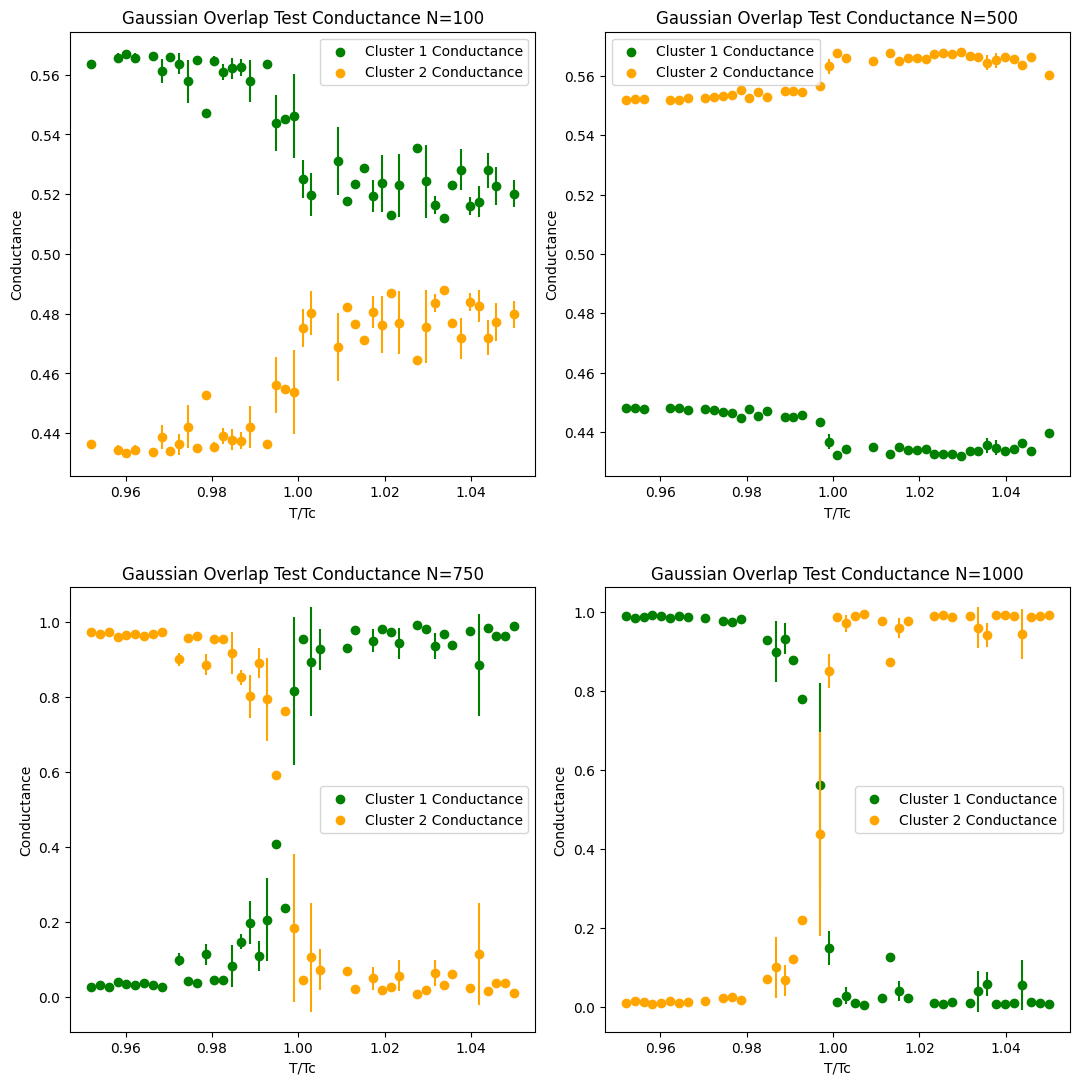

In [32]:
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
for i, Overlap in enumerate(test_OverlapObjects):
    ax = fig.add_subplot(2,2, i + 1)
    binTemp, binConductance0, binConductance1 = Overlap.calculate_conductances(binning = True, bin_range = (0.95, 1.05), xlabels = test_temps[i]/test_Tcs[i], bin_num = 50)
    plt.scatter(binTemp, binConductance0[:,0], label = 'Cluster 1 Conductance', color = 'Green')
    plt.errorbar(binTemp, binConductance0[:,0], yerr = binConductance0[:,1], fmt = 'none', color = 'Green')
    plt.scatter(binTemp, binConductance1[:,0], label = 'Cluster 2 Conductance', color = 'Orange')
    plt.errorbar(binTemp, binConductance1[:,0], yerr = binConductance1[:,1], fmt = 'none', color = 'Orange')
    plt.legend()
    plt.xlabel("T/Tc")
    plt.ylabel("Conductance")
    plt.title(f"Gaussian Overlap Test Conductance N={Ns[i]}")

## RBF Spectral Clustering Comparison

We plot the conductance from our previous method of RBF Spectral Clustering as a point of comparison to our new Gaussian Overlap method.

In [33]:
def binTemps(bin_num, temps, y, Tc, bin_range):
    """
    Sorts temperatures into bins and computes the accuracy for each bin.
    bin_num: The number of bins to be sorted 
    temps: The temperatures used to generate each classified image
    y: The y-axis values that will be averaged when placed into bins. This will typically be an accuracy or conductance value
    Tc: The critical temperature
    bin_range: A tuple containing the maximum and minimum values in the range of bins
    Returns an array of bins and an array of tuples containing the mean and standard deviation of y per bin.
    """
    bins = np.linspace(bin_range[0], bin_range[1], bin_num)
    print(max(temps/Tc))
    tempbins = np.digitize(temps/Tc, bins)
    binVals0 = {}
    for i in range(len(tempbins)):
        if bins[tempbins[i]] in list(binVals0.keys()):
            binVals0[bins[tempbins[i]]].append(y[i])
        else:
            binVals0[bins[tempbins[i]]] = [y[i]]
    for key in binVals0.keys():
        m = np.mean(binVals0[key])
        std = np.std(binVals0[key])
        binVals0[key] = [m, std]
    return np.array(list(binVals0.keys())), np.array(list(binVals0.values()))


def calculateConductances(clusters, matrix):
    """
    Calculates the intracluster conductance for a given set of clusters and the corresponding affinity matrix.
    Returns two arrays containing the conductance for each point relative to each cluster.
    
    Input:
    clusters: An n-dimensional binary array where the ith value represents the assigned cluster for the ith image in the dataset
    matrix: An nxn numpy array containing the affinity between each image in the dataset.
    """
    conductance0 = []
    conductance1 = []
    for v in range(len(clusters)):
        vol = np.sum(matrix[v])
        cutWeights0 = 0
        cutWeights1 = 0
        for w in range(len(clusters)):
            if clusters[w] == 0:
                cutWeights0 += matrix[v,w]
            elif clusters[w] == 1:
                cutWeights1 += matrix[v,w]
        conductanceScore0 = cutWeights0/vol if vol > 0 else 1
        conductanceScore1 = cutWeights1/vol if vol > 0 else 1
        conductance0.append(conductanceScore0)
        conductance1.append(conductanceScore1)
    return conductance0, conductance1

def findAccuracy(temps, Tc, clusters):
    """
    Calculates the accuracy of a given set of cluster labels. Returns a binary array where 1 indicates a correct classification 
    and a 0 indicates an incorrect classification of the corresponding BEC image.
    
    Inputs:
    temps: An array of temperatures 
    Tc: A float representing the unitless critical temperature
    clusters: A numpy binary array determining if each corresponding image is in cluster 0 or cluster 1.
    """
    accuracy = []
    for i,temp in enumerate(temps):
        if (temp < Tc and clusters[i] == 0) or (temp >= Tc and clusters[i] == 1):
            accuracy.append(1)
        else:
            accuracy.append(0)
    accuracy = ((np.array(accuracy))-1)*-1 if sum(accuracy) < 0.5*len(temps) else np.array(accuracy)
    return accuracy

In [34]:
RBFClusters = []
RBFObjects = []
for i in range(len(data)):
    spectral = SpectralClustering(n_clusters = 2, gamma = 600) 
    cluster = spectral.fit_predict(fitImgs[i])
    RBFClusters.append(cluster)
    RBFObjects.append(spectral)

The RBF method does appear to have slightly more success for the smaller values of $N$, as we can see that there is an observable transition for $N = 500$ that is not observable in the gaussian overlap method. However, at $N = 750$ and $N = 1000$, the transitions are very discrete, which is contrary to the smoother transition curves that we are able to (and trying to) observe from the gaussian overlap method.

1.0492529917152484
1.0492529917152484
1.0495523665991622
1.0495523665991622
1.0494793725824472
1.0494793725824472
1.0461849104324168
1.0461849104324168


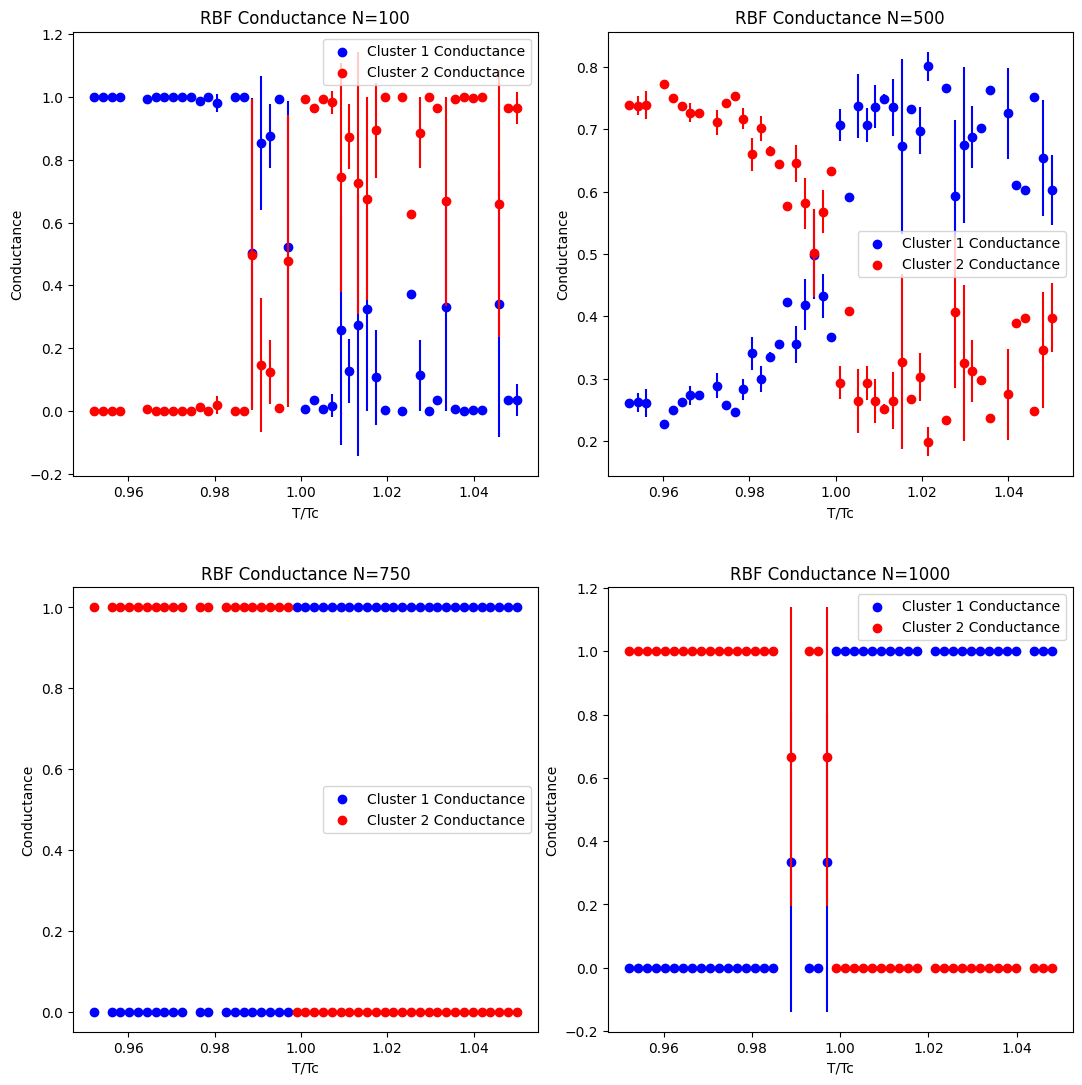

In [35]:
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
for i, spectral in enumerate(RBFObjects):
    ax = fig.add_subplot(2,2, i + 1)
    conductance0, conductance1 = calculateConductances(RBFClusters[i], spectral.affinity_matrix_)
    binTemp, conductance0 = binTemps(50, temps[i], conductance0, Tcs[i], bin_range = (0.95,1.05))
    _, conductance1 = binTemps(50, temps[i], conductance1, Tcs[i], bin_range = (0.95,1.05))
    plt.scatter(binTemp, conductance0[:,0], label = 'Cluster 1 Conductance', color = 'Blue')
    plt.errorbar(binTemp, conductance0[:,0], yerr = conductance0[:,1], fmt = 'none', color = 'Blue')
    plt.scatter(binTemp, conductance1[:,0], label = 'Cluster 2 Conductance', color = 'Red')
    plt.errorbar(binTemp, conductance1[:,0], yerr = conductance1[:,1], fmt = 'none', color = 'Red')
    plt.legend()
    plt.xlabel('T/Tc')
    plt.ylabel('Conductance')
    plt.title(f'RBF Conductance N={Ns[i]}')

The RBF Clustering presents similar accuracy results to the Gaussian Overlap method. Unlike the gaussian overlap method, the RBF method contains a free parameter (gamma) that we must tune manually in order to achieve optimal results. This reveals an advantage of the gaussian overlap method since we are able to achieve comparable classification results to the optimal RBF configuration without having to fine-tune any parameters.

1.0492529917152484
1.0495523665991622
1.0494793725824472
1.0461849104324168


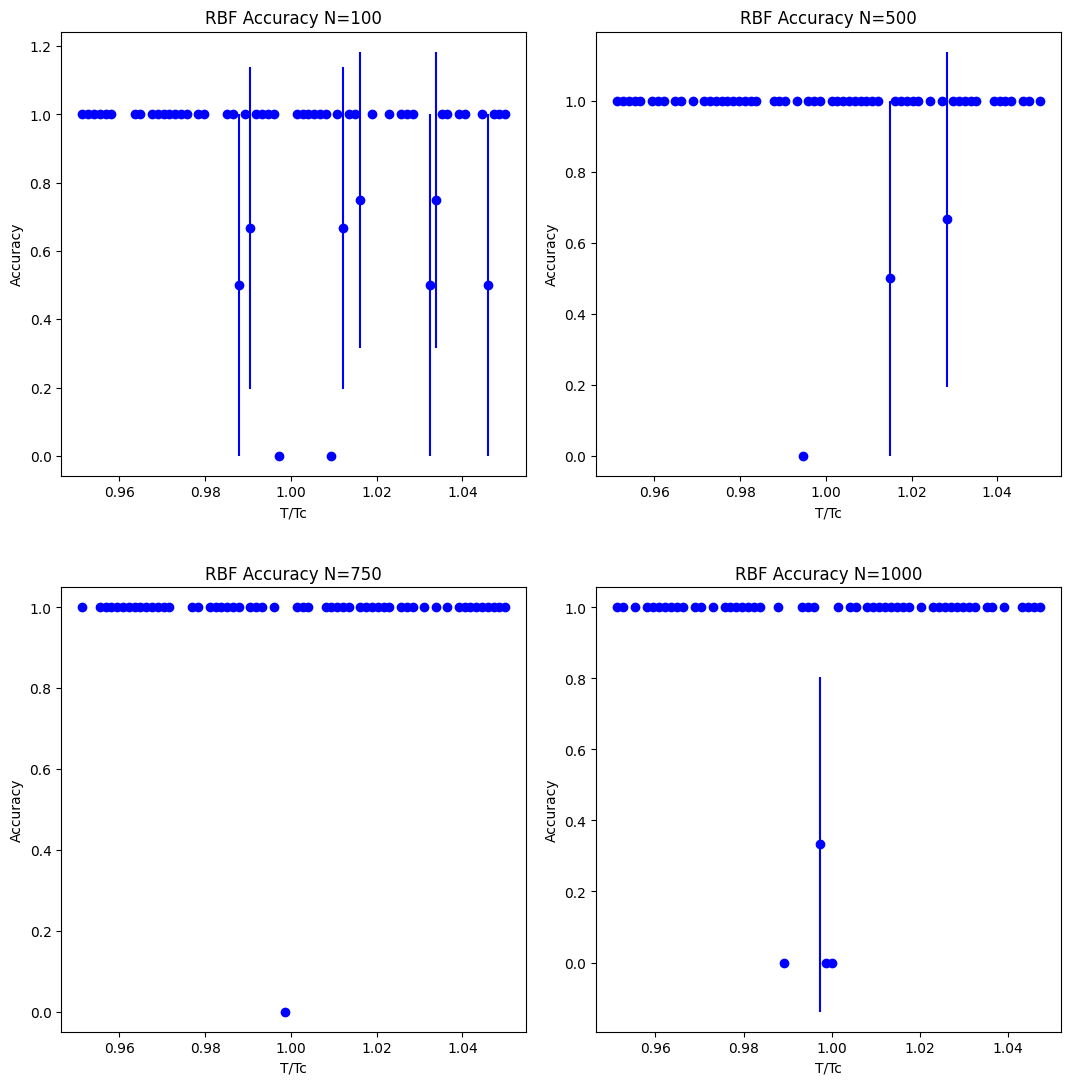

In [36]:
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25, wspace=0.15)
for i, spectral in enumerate(RBFObjects):
    ax = fig.add_subplot(2,2, i + 1)
    accuracies = findAccuracy(temps[i], Tcs[i], RBFClusters[i])
    binTemp, accuracies = binTemps(75, temps[i], accuracies, Tcs[i], bin_range = (0.95, 1.05))
    plt.scatter(binTemp, accuracies[:,0], color = 'Blue')
    plt.errorbar(binTemp, accuracies[:,0], yerr = accuracies[:,1], fmt = 'none', color = 'Blue')
    plt.xlabel('T/Tc')
    plt.ylabel('Accuracy')
    plt.title(f'RBF Accuracy N={Ns[i]}')

## Eigenvalue Analysis

In addition to using the conductance to evaluate the clustering efficacy, we examine the eigenvectors and eigenvalues of the affinity matrix. By sorting each column and row by their assigned cluster, we can determine if the affinity matrix is block diagonal, which would indicate that the data is distinctly (and likely correctly) clustered. As shown below, the $N = 750$ and $N = 1000$ plots have very little affinity on the off-diagonals, indicating very little intercluster connection. While there is still a stronger affinity on the diagonal elements for $N = 100$ and $N = 500$, there is affinity on the off-diagonal elements, indicating weaker clustering on these two datasets.

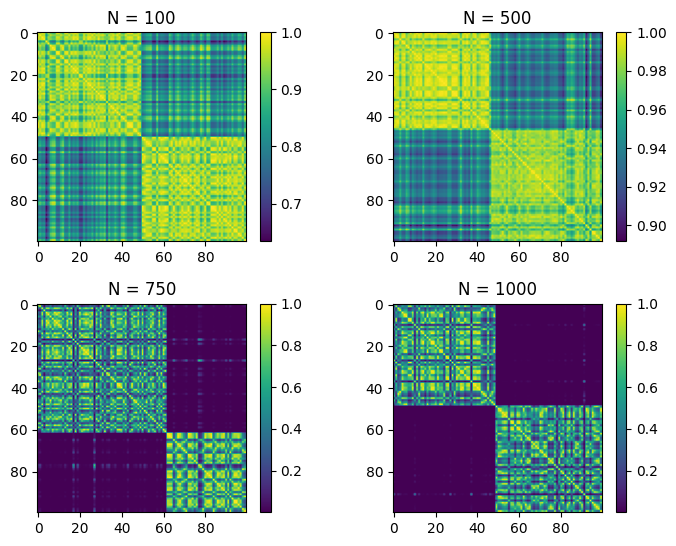

In [37]:
# matrix = overlapMatrix(fitImgs[i], fitSTDs[i])
# clusters = SpectralClustering(n_clusters = 2, affinity='precomputed').fit_predict(matrix)
eigen = []
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.3, wspace=0.25)
for i in range(len(Ns)):
    ax = fig.add_subplot(2,2, i + 1)
    cluster = clusters[i]
    matrix = OverlapObjects[i].affinity_matrix
    order = []
    for j in range(len(matrix)):
        if cluster[j] == 0:
            order.append(j)
    for j in range(len(matrix)):
        if cluster[j] == 1:
            order.append(j)
    newmatrix = (matrix[:, np.array(order)])
    newmatrix2 = newmatrix[np.array(order)]**2
    plt.imshow(newmatrix2)
    plt.colorbar()
    out = lg.eigh(newmatrix2)
    eigen.append(out)
    plt.title(f"N = {Ns[i]}")

We can also examine the eigenvalues of the affinity matrix. A high eigenvalue indicates that the corresponding eigenvector is highly representative of one of the defining features of the dataset. This means that we would expect there to be two eigenvalues that are substantially higher than the rest, representing the features that define the two distinct clusters. We can find how many "high" eigenvalues there are by finding where the largest gap between consecutive descending eigenvalues there are. For the $N = 100$ and $N = 500$ case, there is only one eigenvalue to the left of the gap, indicating suboptimal clustering. Just as is demonstrated by the block diagonal plots above, the two "high" eigenvalues in the $N = 750$ and $N = 1000$ plots indicate proper clustering of the dataset.

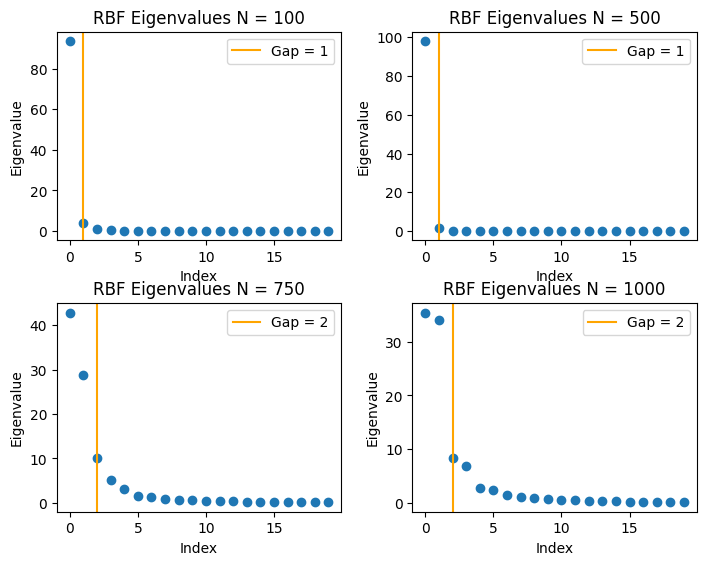

In [38]:
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.3, wspace=0.25)
for i in range(len(data)):
    ax = fig.add_subplot(2,2, i + 1)
    matrix = OverlapObjects[i].affinity_matrix
    lambdas, _ = lg.eigh(matrix)
    lambdas = np.flip(lambdas)
    gaps = np.array([lambdas[i] - lambdas[i + 1] for i in range(len(lambdas) - 1)])
    largeE = lambdas[:np.where(gaps == np.max(gaps))[0][0] + 1]
    k = len(largeE)
    plt.scatter(np.arange(0,20, 1), lambdas[:20])
    plt.axvline(k, color = 'orange', label = f'Gap = {k}')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.title('RBF Eigenvalues N = {}'.format(Ns[i]))